In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from datetime import date, datetime
import datetime
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy.spatial.distance import euclidean
from sklearn.feature_selection import f_regression
from statsmodels.tsa.stattools import adfuller
from sklearn.manifold import TSNE
from DBCV import DBCV
import hdbscan
import csv
import multiprocessing
import itertools
import operator
import math
from dtaidistance import dtw
import seaborn as sns
import json
plt.style.use('fivethirtyeight')
from osgeo import gdal 
from subprocess import Popen
import simplekml
import copy
from sklearn.cluster import DBSCAN
import numpy.ma as ma

In [2]:
DATA_PATH = './donnees'

In [4]:
def to_date(str):
    str_strp = str.strip()
    year, month, day = int(str_strp[0:4]), int(str_strp[4:6]), int(str_strp[6:8])
    return date(year, month, day)
DATA_PATH = './donnees'
def load_data(filename):

    # numéro de la ligne ou commence les données
    num_start = 44
    # numéro de la ligne ou se trouve la liste des dates
    num_list_dates = 40
    # attributs présent dans les données
    columns = ['id', 'Lat','Lon', 'Topo', 'Vel', 'Coer',' CosN', 'CosE', 'CosU']
    # dictionnaire stockant les données
    data = {column: [] for column in columns}
    # liste des dates 
    indexes = []
    # series temporelles
    series = []
    # liste de dataframes
    df_series = []

    with open(DATA_PATH + '/' + filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        line_count = 1 
        for row in csv_reader:
            if line_count == num_list_dates:
                indexes = [row[0].split(' ')[1]] + row[1:]
            if line_count >= num_start:
                # extraction des premiers attributs
                for i in range(len(columns)):
                    data[columns[i]].append(row[i])
                # extraction de l'attribut TS(série temporelle)
                series.append([float(v) for v in row[len(columns):]])
            line_count  += 1
        if len(indexes) != len(series[0]):
            print('Erreur : Les indexes et les valeurs ne correspondent pas')
        # convertir les index en date
        indexes = [d.strip()[0:8] for d in indexes]
        # créer une liste de dataframes, chacun contenant une série temporelle
        for serie in series:
            tmp_serie = pd.DataFrame({'displacement': pd.Series(serie, index=pd.DatetimeIndex(indexes))})
            tmp_serie.sort_index(inplace=True)
            df_series.append(tmp_serie)
        # creer un dataframe pour les autres attributs
        df = pd.DataFrame(data)
        for column in df.columns:
            df[column] = pd.to_numeric(df[column], errors='coerce')
        df.set_index('id')
        
    return df, df_series


def get_ids(df, column='id'):
    
    return df[column].tolist()
        
def impute(series, ids, pc=0.4):
    
    result = []
    ids_to_not_keep = []
    n_samples = len(series[0])
    
    for i in range(len(series)):
        if 100*(series[i].isnull().sum().sum()/n_samples) < pc:
            result.append(series[i].interpolate(limit_direction='both', inplace=False))
        else:
            ids_to_not_keep.append(ids[i])
            
    return result, ids_to_not_keep

def imputed(serie, index=None):
    
    # dataframe resultat
    result = None
    
    # liste des identifiants des valeurs manquantes
    rows_with_nan = [index for index, row in serie.iterrows() if row.isnull().any()]
    
    if index is None:
        result = serie.dropna(inplace=False)
        
    if isinstance(index, list):
        pass
        
    return result, rows_with_nan
        

# imputer les données
def impute_(ns_series, ew_series, pc=0.4):

    # nombre de mésures
    n = len(ns_series[0])
    
    # recupérer les series de la composante Nord-Sud qui ont un pourcentage de valeurs manquuantes inferieur à 50%
    ns_booleans  = [True if (ns_series[i].isnull().sum().sum()/n) < pc else False for i in range(len(ns_series))]
    # recupérer les series de la composante Est-Ouest qui ont un pourcentage de valeurs manquuantes inferieur à 50%
    ew_booleans  = [True if (ew_series[i].isnull().sum().sum()/n) < pc else False for i in range(len(ew_series))]
    # Conserver uniquement les points où la norme du vecteur vitesse est calculable
    booleans     = [True if i and j else False for i, j in zip(ns_booleans, ew_booleans)]
    
    # suppression des séries temporelles qui ont un pourcentage de valeurs manquantes supérieure ou égale à 0.5
    ns_series_c = [d for d in itertools.compress(ns_series, booleans)]
    ew_series_c = [d for d in itertools.compress(ew_series, booleans)]
    
    # interpoler les valeurs manquantes des les séries restantes
    for i in range(len(ns_series_c)):
        if ns_series_c[i].isnull().sum().sum() > 0:
            ns_series_c[i].interpolate(limit_direction='both', inplace=True)
        if ew_series_c[i].isnull().sum().sum() > 0:
            ew_series_c[i].interpolate(limit_direction='both', inplace=True)
            
    return ns_series_c[0].index, ew_series_c, ns_series_c

In [5]:
class TimeSerie():
    
    def __init__(self):
        pass
    
    def has_null_values(self, serie):
        return self.count_null_values(serie) > 0
    
    def count_null_values(self, serie):
        return serie.isnull().sum().sum()
    
    def compute_null_val_percentage(self, serie):
        return 100 *(1.0 * self.count_null_values(serie) / len(serie))
    
    def interpolate(self, serie):
        return serie.interpolate(limit_direction='both', inplace=False)
    
    def compute_pearson_coef(self, serie):
        return stats.pearsonr(np.squeeze(serie.values), get_days(serie.index))
    
    def compute_linear_reg_pval(self, serie):
        # extraire X et y
        X, y = self.prepare(serie)
        # calculer la p-value de la regression lineaire
        _, pval = f_regression(X,y.ravel())
        return  pval[0]
        
    def select(self, serie, filename, ref, min_slope, alpha, sigma, ampl, pc):
        slope   = self.get_slope_value(ref, serie, filename)
        p_value = self.get_linear_reg_pval(serie, alpha)
        vlm = self.vlm
        # filtrage des series avec peu de valeurs
        if self.compute_nul_val_percentage > pc:
            return False
        # filtrage des regressions non significatives
        if p_value > alpha:
            return False
        # filtrage des vitesses faibles
        if abs(vlm) < ampl* sigma:
            return False
         # filtrage des pentes faibles
        if slope < min_slope:
            return False
        # sauvegarder l'état du pixel
        self.set_selected()
        return True
    
    def normalize(self):
        return StandardScaler().fit_transform(self.serie)
    
    # la copie renvoie bien un nouvel objet, il n'y a pas d'effets de bord
    def smooth(self, s, ampl):
        serie = s.copy()
        std = math.sqrt(serie.var())
        for i in range(len(serie)):
            if abs(serie.iloc[i].displacement) > ampl*std:
                serie.iloc[i, serie.columns.get_loc('displacement')]= np.nan
        return serie.interpolate(limit_direction='both', inplace=False)
    
    def detect_trend(self, alpha):
        X, y = self.prepare()
        # calculer la p-value de la regression lineaire
        _, pval = f_regression(X,y.ravel())
        self.set_linear_reg_pvalue(pval)
        # eliminer le bruit si la regression n'est pas significative (bourrage de zeros)
        if pval > alpha:
            #return self.clone(pd.DataFrame(0.0, index=self.serie.index, columns=self.serie.columns))
            return self.deepcopy(pd.DataFrame(0.0, index=self.serie.index, columns=self.serie.columns))  
        else:
            #return self.clone(self.serie.copy())
            return self.deepcopy(self.serie)
    
    def transform(self, alpha):
        return smooth().detect_non_moving_serie(alpha)
        
    def deepcopy(self, serie):
        clone = copy.deepcopy(self)
        clone.set_serie(serie)
        return clone
        
    def compute_adfuller(self, serie):
        adf_result = adfuller(serie)
        adf_output = pd.Series(adf_result[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key, value in adf_result[4].items():
            adf_output['Critical Value (%s)'%(key)] = value
        return adf_output[1]
    
    # ce test nécessite d'avoir des données regulièrement échantillonnées
    # Hyopthèse nulle : il existe une racine unitaire (série croissante ou cyclique)
    # Hypthèse alternative : il n'existe pas de racine unitaire (série stationnaire)
    # Si la p-valeur du test est inférireure à O.05, on rejette l'hypothèse nulle et la sériee est stationnaire
    # NB: on recherche des signaux non stationnaires 
    def is_stationary(self, serie, freq='D', alpha=0.05):
        resampled = serie.resample(freq)
        interpolated = upsampled.interpolate(method='linear')
        return self.compute_adfuller(interpolated) < alpha
    
    def get_days(self, serie):
        days = []
        dates = serie.index
        for i in range(len(dates)):
            days.append(abs((dates[0] - dates[i]).days ))
        return days

    def get_Xy(self, serie):
        X = get_days(serie.index)
        y = StandardScaler().fit_transform(serie)
        return np.array(X).reshape(-1,1), y
    
    def prepare(self, serie):
        # transformer les index en durée pour pouvoire effectuer une regression linéaire
        X = np.array([abs((serie.index[0] - serie.index[n]).days) for n in range(len(serie.index))]).reshape(-1,1)
        # extraire la cible
        y = StandardScaler().fit_transform(serie)
        return X, y
    
    # that functions gives approximately the same result when use sklearn linear regression
    # x and y and numpy array
    def compute_slope(self, serie):
        x, y = self.prepare(serie)
        return np.cov(x.T, y.T)[0][1] / np.var(x)
    
    def compute_inst_vel(self, serie):
        vels =  []
        for i in range(1, len(serie)-1):
            duration = (serie.index[i+1] - serie.index[i-1]).days
            displacement = serie.iloc[i+1].values[0] - serie.iloc[i-1].values[0]
            vels.append(displacement / duration)
        return pd.DataFrame(vels, index=serie.index[1:-1], columns=['vel'])
    
    def impute(self, serie,):
        if self.has_null_values(serie):
            return serie.interpolate(limit_direction='both', inplace=False)
        else:
            return serie
        
    def compute_diff_vect(self, serie):
        disp     = np.diff(np.squeeze(serie.values))
        duration = np.diff(np.squeeze(serie.index)) /  np.timedelta64(1,'D')
        return disp, np.cumsum(duration)
        

In [6]:
class Pixel(TimeSerie):
    
    def __init__(self, id_, lat, lon, topo, ns, ew, ns_vel, ew_vel):
        super(TimeSerie, self).__init__()
        self.id = id_
        self.lat = lat
        self.lon = lon
        self.topo = topo
        self.ns = self.impute(ns)
        self.ew = self.impute(ew)
        self.ns_vel = ns_vel
        self.ew_vel = ew_vel
        self.is_selected = False
    
    def compute_magnitude_displacement(self):
        x = self.ns.iloc[-1]
        y = self.ew.iloc[-1]
        return math.sqrt(x*x + y*y)
    
    def compute_sign_change_proportion_ns(self):
        pos, neg = 0, 0
        for n in range(len(self.ns)):
            if self.ns.iloc[n].values[0] > 0:
                pos += 1
            else:
                neg += 1
        return 1.0*pos/len(self.ns), 1.0*neg/len(self.ns)
    
    def compute_sign_change_proportion_ew(self):
        pos, neg = 0, 0
        for n in range(len(self.ew)):
            if self.ew.iloc[n].values[0] > 0:
                pos += 1
            else:
                neg += 1
        return 1.0*pos/len(self.ew), 1.0*neg/len(self.ew)
    
    # Pour des zones stables avec beaucoup de bruit ou avec peu de déplacement
    # La médiane donne une estimation du déplacement proche de zero.
    # NCC : normalized cross-correlation (cosine similarity)
    def compute_median_displacement():
        pass
    
    def remove_zero_displacement():
        pass
    def remove_noisy():
        pass
    
    def compute_vector_coherence(self):
        diff_ns = np.diff(np.squeeze(self.ns.values))
        diff_ew = np.diff(np.squeeze(self.ew.values))
        num = self.compute_norm(np.sum(diff_ns), np.sum(diff_ew))
        den = np.sum(self.compute_norm(diff_ns, diff_ew))
        return num / den 
    
    def compute_norm(self, x, y):
        return np.sqrt(x*x + y*y)
    
    def has_enough_values(self, pc):
        return self.compute_null_val_percentage(self.ns) < pc
    
    def is_linear_regression_significant(self, alpha, ampl):
        ns_sm = self.smooth(self.ns, ampl)
        ew_sm = self.smooth(self.ew, ampl)
        return self.compute_linear_reg_pval(ns_sm) < alpha or self.compute_linear_reg_pval(ew_sm) < alpha
    
    def is_ns_linear_regression_significant(self, alpha):
        return self.compute_linear_reg_pval(self.ns) < alpha
        
    def is_ew_linear_regression_significant(self, alpha):
        return self.compute_linear_reg_pval(self.ew) < alpha
    
    def is_linear_regression_significant_(self, alpha):
        return self.is_ns_linear_regression_significant(alpha) or self.is_ew_linear_regression_significant(alpha)
    
    def is_steep(self, filename, ref, min_slope):
        return self.compute_slope(ref, filename) > min_slope
    
    def compute_vel(self, ns_component, ew_component):
        return math.sqrt(ns_component * ns_component + ew_component * ew_component)
    
    def is_moving(self, std, factor):
        return self.get_mean_velocity() > factor*std
    
    def is_to_select(self, filename, ref, alpha, min_slope, std, factor, pc, ampl_disp):
        return self.is_linear_regression_significant(alpha, ampl_disp) and self.is_moving(std, factor) and self.is_steep(filename, ref, min_slope)
    
    def is_to_select2(self, filename, ref, min_slope, vel_std, amplitude):
        return self.is_moving(vel_std, amplitude) and self.is_steep(filename, ref, min_slope)
    
    def is_to_select3():
        pass
        
    def compute_slope(self, ref, file):
        val = os.popen('gdallocationinfo -valonly -%s %s %f %f' % (ref, file, self.lat, self.lon)).read()
        if len(val) == 0:
            raise ValueError('La pente est non valide !')
        return  float(val)
    
    def get_mean_velocity(self):
        return math.sqrt(self.ns_vel*self.ns_vel + self.ew_vel*self.ew_vel)
    
    def compute_interquartile_range(self, serie):
        s = serie.copy().sort_values(by=serie.columns[0], ascending=True)
        q3, q1 = np.percentile(s, [75 ,25])
        iqr = q3 - q1
        return q1 - 1.5 * iqr, q3 + 1.5 * iqr
    
    def smooth_by_iqr(self, serie):
        colum = serie.columns[0]
        low, up = self.compute_interquartile_range(serie)
        for n in range(len(serie)):
            if serie.values[n][0] < low or serie.values[n][0] > up:
                serie.iloc[i, serie.columns.get_loc('displacement')]= np.nan
        return serie.interpolate(limit_direction='both', inplace=False)
    
    def is_sign_random(self):
        ns_prop = self.compute_sign_change_proportion_ns()
        ew_prop = self.compute_sign_change_proportion_ew()
        return abs(ns_prop[0] - ns_prop[1]) > 0.5 or abs(ew_prop[0] - ew_prop[1]) > 0.5

In [7]:
def to_date(str):
    str_strp = str.strip()
    year, month, day = int(str_strp[0:4]), int(str_strp[4:6]), int(str_strp[6:8])
    return date(year, month, day)
DATA_PATH = './donnees'
def load_data(filename):

    # numéro de la ligne ou commence les données
    num_start = 44
    # numéro de la ligne ou se trouve la liste des dates
    num_list_dates = 40
    # attributs présent dans les données
    columns = ['id', 'Lat','Lon', 'Topo', 'Vel', 'Coer',' CosN', 'CosE', 'CosU']
    # dictionnaire stockant les données
    data = {column: [] for column in columns}
    # liste des dates 
    indexes = []
    # series temporelles
    series = []
    # liste de dataframes
    df_series = []

    with open(DATA_PATH + '/' + filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        line_count = 1 
        for row in csv_reader:
            if line_count == num_list_dates:
                indexes = [row[0].split(' ')[1]] + row[1:]
            if line_count >= num_start:
                # extraction des premiers attributs
                for i in range(len(columns)):
                    data[columns[i]].append(row[i])
                # extraction de l'attribut TS(série temporelle)
                series.append([float(v) for v in row[len(columns):]])
            line_count  += 1
        if len(indexes) != len(series[0]):
            print('Erreur : Les indexes et les valeurs ne correspondent pas')
        # convertir les index en date
        indexes = [d.strip()[0:8] for d in indexes]
        # créer une liste de dataframes, chacun contenant une série temporelle
        for serie in series:
            tmp_serie = pd.DataFrame({'displacement': pd.Series(serie, index=pd.DatetimeIndex(indexes))})
            tmp_serie.sort_index(inplace=True)
            df_series.append(tmp_serie)
        # creer un dataframe pour les autres attributs
        df = pd.DataFrame(data)
        for column in df.columns:
            df[column] = pd.to_numeric(df[column], errors='coerce')
        df.set_index('id')
        
    return df, df_series

In [8]:
class DataFromImageCorrelation():
    
    def __init__(self, pixels, raster_folder_name, dem_filename, pc=0.4, alpha=0.05, ref='wgs84'):
        self.pixels  = pixels
        self.compute_slope_map(raster_folder_name, dem_filename)
        self.n_cores = multiprocessing.cpu_count()
        self.non_filtered_ids = []
        self.pc = pc
        self.ref = ref
        self.alpha = alpha
        self.sigma = self.compute_vlm_std()
        self.velocities = []
        self.mask = []
    
    def compute_vel(self, ns_component, ew_component):
        return math.sqrt(ns_component * ns_component + ew_component * ew_component)
    
    def test_filter(self, factor, min_slope=5):
        self.non_filtered_ids.clear()
        self.compute_vlm_std()
        vfunc = np.vectorize(self.is_to_select)
        x = vfunc(np.arange(len(self.pixels)), factor)
        self.non_filtered_ids = x.nonzero()[0].tolist()
                
    def filter_by(self, factor):
        self.non_filtered_ids.clear()
        self.compute_vlm_std()
        vfunc = np.vectorize(self.debug_is_to_select)
        x = vfunc(np.arange(len(self.pixels)), factor)
        print(x, len(x))
        self.non_filtered_ids = x.nonzero()[0].tolist()
        
    def filter_by5(self, factor):
        self.non_filtered_ids.clear()
        for n in range(len(self.pixels)):
            if self.debug_is_to_select(n, factor):
                self.non_filtered_ids.append(n)
            
    def is_to_select(self, n, factor):
        return (self.pixels[n].get_mean_velocity() > factor * self.sigma and 
               (self.pixels[n].is_ns_linear_regression_significant(self.alpha) or
               self.pixels[n].is_ew_linear_regression_significant(self.alpha)) )
    
    def debug_is_to_select(self, n, factor):
        return not (self.pixels[n].get_mean_velocity() > factor * self.sigma)
    
    def debug_filter_by(self, factor=1):
        vfunc = np.vectorize(self.debug_is_to_select)
        return vfunc(np.arange(len(self.pixels)), factor)
    
    def filter_by_linear_reg(self):
        self.non_filtered_ids.clear()
        for n in range(len(self.pixels)):
            is_ns_sig = self.pixels[n].is_ns_linear_regression_significant(self.alpha)
            is_ew_sig = self.pixels[n].is_ew_linear_regression_significant(self.alpha)
            if is_ns_sig or is_ew_sig:
                self.non_filtered_ids.append(n)
                
    def select_by_vel(self, ampl, std):
        pass
                
    def filter2(self, amplitudes=np.arange(start=2, stop=10, step=0.5), threshold=0.5, min_slope=5):
        n_pixels = len(self.pixels)
        self.compute_vlm_std()
        for amplitude in amplitudes[::-1]:
            self.non_filtered_ids.clear()
            for n in range(len(self.pixels)):
                if self.pixels[n].is_to_select2(self.slope_map_path, self.ref, min_slope, self.sigma, amplitude):
                    self.non_filtered_ids.append(n)
            ratio  = 1.0*len(self.non_filtered_ids) / n_pixels
            if ratio > threshold:
                break
                
    def compute_vlm_std(self):
        return np.std(np.array([math.sqrt(pixel.ns_vel*pixel.ns_vel + pixel.ew_vel*pixel.ew_vel) for pixel in self.pixels]))
    
    def compute_inst_vels(self, series):
        with multiprocessing.Pool(self.n_cores) as p:
            results = p.map(TimeSerie().compute_inst_vel, series)
            return results
        
    def compute_velocities2(self):
        self.velocities.clear()
        if len(self.non_filtered_ids) == 0:
            self.non_filtered_ids = np.arange(len(pixels))
        ns_vels = self.compute_inst_vels([self.pixels[n].ns for n in self.non_filtered_ids])
        ew_vels = self.compute_inst_vels([self.pixels[n].ew for n in self.non_filtered_ids])
        for i in range(len(ns_vels)):
            vels = []
            column = ns_vels[0].columns[0]
            for ns_vel, ew_vel in zip(ns_vels[i][column], ew_vels[i][column]):
                vels.append(self.compute_vel(ns_vel, ew_vel))
            df = pd.DataFrame(vels, index=ns_vels[0].index, columns=['magnitude'])
            self.velocities.append(df)
        
    def compute_velocities(self, min_slope, ampl, ampl_disp):
        self.velocities.clear()
        self.select(min_slope, ampl, ampl_disp)
        if len(self.non_filtered_ids) > 0:
            ns_vels = self.compute_inst_vels([self.pixels[n].ns for n in self.non_filtered_ids])
            ew_vels = self.compute_inst_vels([self.pixels[n].ew for n in self.non_filtered_ids])
            for i in range(len(ns_vels)):
                vels = []
                column = ns_vels[0].columns[0]
                for ns_vel, ew_vel in zip(ns_vels[i][column], ew_vels[i][column]):
                    vels.append(self.compute_vel(ns_vel, ew_vel))
                df = pd.DataFrame(vels, index=ns_vels[0].index, columns=['magnitude'])
                self.velocities.append(df)
    
    def select(self, min_slope, factor, ampl_disp):
        self.non_filtered_ids.clear()
        for n in range(len(self.pixels)):
            if self.pixels[n].is_to_select(self.slope_map_path, self.ref, self.alpha, min_slope, self.sigma, factor, self.pc, ampl_disp):
                self.non_filtered_ids.append(n)
                
    def set_slope_map_path(self, slope_map_path):
        self.slope_map_path = slope_map_path
        
    def load_raster(self, raster_folder_name, raster_filename):
        return gdal.Open(raster_folder_name + '/' +  raster_filename)
        
    def compute_slope_map(self, raster_folder_name, dem_name):
        dem = None
        slope_map = None
        slope_map_name = dem_name.split('.')[0] + '_' + 'slope_map.tif'
        slope_map_path = raster_folder_name + '/' + slope_map_name
        if not os.path.isfile(slope_map_path):
            dem = gdal.Open(raster_folder_name + '/'+ dem_name)
            slope_map = gdal.DEMProcessing(slope_map_path, dem, 'slope', computeEdges = True)
        self.set_slope_map_path(slope_map_path)

In [9]:
class Clustering():
    
    def __init__(self, data, option=0):
        self.data = data
        self.result = None
        self.n_clusters = None
        self.option = option
        
    def select_scaler(serie):
        if self.option == 0:
            return StandardScaler().fit_transform(serie)
        else:
            return RobustScaler.fit_transform(serie)
        
    def get_scaler(self):
        if self.option == 0:
            scaler = RobustScaler()
        else:
            scaler = StandardScaler()
        return scaler
    
    def normalize(self, series):
        scaler = self.get_scaler()
        return np.array([scaler.fit_transform(serie).reshape(len(serie)) for serie in series])
    
    def compute_similarity_matrix(self, series):
        velocities =  self.data.velocities
        size = len(series)
        distances_matrix = np.zeros(shape=(size, size))
        scaler = self.get_scaler()
        for n in range(size):
            for m in range(n , size):
                s1 = scaler.fit_transform(velocities[n])
                s2 = scaler.fit_transform(velocities[m])
                dist = dtw.distance(s1, s2)
                distances_matrix[n, m] = dist
                distances_matrix[m, m] = dist
        return distances_matrix
    
    def cluster(self, min_cluster_size, min_samples=10, precomputed=False):
        data = self.data.velocities
        if not precomputed:
            self.result = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,  gen_min_span_tree=True).fit(self.normalize(data))
        else:
            self.result = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, gen_min_span_tree=True, metric='precomputed').fit(self.compute_similarity_matrix(data))

    def get_n_clusters(self):
        return 0 if self.result.labels_.max() < 0 else self.result.labels_.max() + 1
    
    def visualize(self):
        projection = TSNE().fit_transform(self.normalize(self.data.velocities))
        color_palette = sns.color_palette('Paired', self.result.labels_.max() + 1 )
        cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in self.result.labels_]
        cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, self.result.probabilities_)]
        plt.scatter(*projection.T, s=20, c=cluster_member_colors , linewidth=0, alpha=0.25)
        plt.savefig('tsne.png')
        plt.show()
    
    def plot_cluster_distribution(self, colormap='Dark2'):
        v_count = dict()
        cmap = plt.get_cmap(colormap)
        colors = [cmap(i) for i in np.linspace(0, 1, self.result.labels_.max() + 1)]
        for label in self.result.labels_:
            if label != -1:
                if label in v_count.keys():
                    v_count[label] += 1
                else:
                    v_count[label] = 1
        pd.Series({k: v for k, v in sorted(v_count.items(), key=lambda item: item[0])}).plot(kind='bar', color=colors)
        return v_count
    
    def get_data_from_class(self, num_label):
        data = []
        for i in range(len(self.result.labels_)):
            if self.result.labels_[i] == num_label:
                data.append(self.data[i])
        return data
    
    def plot_cluster_result(self, n_cols=3):
        labels = self.result.labels_
        n_clusters = labels.max() + 1
        n_rows = int(n_clusters / n_cols) if n_clusters % n_cols == 0 else int(math.ceil(n_clusters / n_cols))
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(25,15))
        for num_cluster in range(n_clusters):
            for serie_index in range(len(self.data.magnitudes)):
                if labels[serie_index] == num_cluster:
                    axs[int(num_cluster / n_cols), num_cluster % n_cols].plot(self.data.magnitudes[serie_index], c='blue', alpha=0.2)
            axs[int(num_cluster / n_cols), num_cluster % n_cols].set_title('Cluster %d'%(num_cluster + 1))
        fig.tight_layout()
        plt.show()
        
    # créer un fichier csv contenant les champs : id, lat, lon, numero de la classe
    def generate_csv_file(self):
        rows = []
        fieldnames = ['id', 'Lat', 'Lon', 'cluster']
        data =  self.data.pixels
        non_filtered_ids = self.data.non_filtered_ids
        for n in range(len(non_filtered_ids)):
            rows.append({'id': int(data[n].id), 'Lat': data[n].lat, 'Lon': data[n].lon, 'cluster': self.result.labels_[n]})
        with open('clustering_result.csv', 'w', encoding='UTF8', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(rows)
            
    # le nombre de markers est limité, on ne prend que les 8 premières classes
    def get_important_labels(self, labels, n_classes=8):
        classes = []
        unique, counts = np.unique(labels, return_counts=True)
        sort_labels = sorted(dict(zip(unique, counts)).items(), key=lambda x: x[1], reverse=True)
        for label, count in sort_labels:
            if label > -1 and len(classes) < n_classes:
                classes.append(label)
        return classes

    def generate_kml_file2(self):
        if self.result.labels_.max() > -1:
            icones = self.generate_icones2()
            labels = self.get_important_labels(self.result.labels_)
            kml=simplekml.Kml()
            fol = kml.newfolder(name="HDBSCAN Clustering")
            for i, n in enumerate(self.data.non_filtered_ids, 0):
                if self.result.labels_[i] in labels:
                    ind = labels.index(self.result.labels_[i])
                    pnt = fol.newpoint(description=str(n), coords=[(self.data.pixels[n].lat, self.data.pixels[n].lon)])
                    pnt.iconstyle.icon.href = icones[ind]
            kml.save('clustering_result.kml')
        else:
            print('Hdbscan only found outliers. kml file cannot be generated !')

    def generate_kml_file(self, scale=2):
        labels = self.result.labels_
        if labels.max() > -1:
            icon_links, scales = self.generate_icones(labels)
            kml=simplekml.Kml()
            fol = kml.newfolder(name="HDBSCAN Clustering")
            labels = self.result.labels_
            for i, n in enumerate(self.data.non_filtered_ids, 0):
                if labels[i] > - 1:
                    pnt = fol.newpoint(description=str(n), coords=[(self.data.pixels[n].lat, self.data.pixels[n].lon)])
                    pnt.iconstyle.icon.href =icon_links[labels[i]]
                    pnt.style.labelstyle.scale = scales[labels[i]]
            kml.save('clustering_result.kml')
        else:
            print('Hdbscan only found outliers. kml file cannot be generated !')
            
    def get_pixel_icon(self, m):
        labels = self.result.labels_
        icon_links, _ = self.generate_icones(labels)
        for i, n in enumerate(self.data.non_filtered_ids, 0):
            if n == m:
                return icon_links[labels[i]]
            
    def generate_icones2(self):
        base = 'http://maps.google.com/mapfiles/ms/micons/'
        colors = ['blue', 'red', 'yellow', 'green', 'orange', 'purple', 'pink']
        return [base + color + '-dot.png' for color in (colors + ['ltblue'])[:]] + [base + color + '.png' for color in (colors + ['lightblue'])[:]]
            
    #http://tancro.e-central.tv/grandmaster/markers/google-icons/mapfiles-ms-micons.html
    def generate_icones(self, labels, scale=2):
        BASE = 'http://maps.google.com/mapfiles/ms/micons/'
        scales = None
        colors = ['blue', 'red', 'yellow', 'green', 'orange', 'purple', 'pink']
        icon_links = [BASE + color + '-dot.png' for color in (colors + ['ltblue'])[:]] + [BASE + color + '.png' for color in (colors + ['lightblue'])[:]]
        n_clusters = labels.max() + 1
        if n_clusters > len(icon_links):
            q = int(n_clusters / len(icon_links))
            r = n_clusters - q*len(icon_links)
            icon_links = (icon_links*q)[:] + icon_links[:r]
            scales = [scale*t for t in range(len(icon_links))]
        else:
            scales = [scale]*n_clusters
        return icon_links, scales
    
    # coefficient de silhouette ?
    def validate(self):
        return DBCV(self.data.magnitudes, self.result.labels_, dist_function=euclidean)

In [10]:
class Utility():
    
    url = 'http://maps.google.com/mapfiles/ms/micons/'
    
    def __init__(self):
        pass
    
    def generate_kml_file(self, latitudes, longitudes, color, kml=None, filename='visualization', generate=True):
        
        kml_obj = None
        fol = None
        if kml is None:
            kml_obj = simplekml.Kml()
        else:
            kml_obj = kml
            
        for n, coords in enumerate(zip(latitudes, longitudes)):
            pnt = kml_obj.newpoint(description=str(n), coords=[(coords[0], coords[1])])
            pnt.iconstyle.icon.href = self.url + color + '-dot.png'
        
        if generate:
            kml.save(filename + '.kml')
            return  None
        else:
            return kml
        
    def generate_kml_file_classes(self, latitudes1, longitudes1, latitudes2, longitudes2, output_filename='visualization', color1='red', color2='green'):
        
        kml = self.generate_kml_file(latitudes1, longitudes1, color1, generate=False)
        _ = self.generate_kml_file(latitudes2, longitudes2, color2, generate=True)
            
        kml.save(output_filename + '.kml')

In [11]:
class Visualization():

    def __init__(self):
        pass
    
    def plot_displacement(self, ts):
        
        days = get_days(ns_ts.index)
        fig, ax = plt.subplots(figsize=(15,5))
    
        ax[0].plot(ns_ts['displacement'], color='blue', label='NS displacement (m)', marker='o', linewidth=2)
        ax[1].plot(ew_ts['displacement'], color='orange', label='EW displacement (m)', marker='o', linewidth=2)
        
        plt.legend()
        plt.legend(loc='best')
        plt.show()
    
    def plot_displacement_vel(self, ns_ts, ew_ts):
        
        days = get_days(ns_ts[0].index)

        fig, ax_left = plt.subplots(figsize=(15,5))
        ax_right = ax_left.twinx()

        p1, = ax_left.plot(days, df_series[4]['displacement'], color='blue', label='NS displacement (m)')
        p2, = ax_right.plot(days, df_series[4]['displacement'], color='orange', label='EW displacement(m)')

        ax_left.set_xlabel("number of days since the first measure")
        ax_left.set_ylabel("displacement")
        ax_right.set_ylabel("velocity")

        lns = [p1, p2]

        ax_left.legend(handles=lns, loc='best')
        fig.tight_layout()
        plt.show()
        
    def plot_disp_ns_ew(self, ns_ts, ew_ts):

        fig, ax = plt.subplots(2, 1, figsize=(15,10))

        ax[0].plot(ns_ts, color='blue', label='displacement (m)', marker='o', linewidth=2)
        ax[0].set_title('NS cumulative displacement')
        ax[0].set_xlabel('time')
        ax[0].set_ylabel('displacement')
        ax[0].legend()

        ax[1].plot(ew_ts, color='orange', label='displacement (m)', marker='o', linewidth=2)
        ax[1].set_title('EW cumulative displacement')
        ax[1].set_xlabel('time')
        ax[1].set_ylabel('displacement')
        ax[1].legend()
        plt.savefig('displacement.png')
        fig.tight_layout()
        plt.show()
        
    def plot_disp_vel(self, ns_ts, ew_ts, vels):
        
        fig, ax = plt.subplots(3, 1, figsize=(15,10))

        ax[0].plot(ns_ts, color='blue', label='displacement (m)', marker='o', linewidth=2)
        ax[0].set_title('NS cumulative displacement')
        ax[0].set_xlabel('time')
        ax[0].set_ylabel('displacement')
        ax[0].legend()

        ax[1].plot(ew_ts, color='orange', label='displacement (m)', marker='o', linewidth=2)
        ax[1].set_title('EW cumulative displacement')
        ax[1].set_xlabel('time')
        ax[1].set_ylabel('displacement')
        ax[1].legend()

        ax[2].plot(vels, color='green', label='vxelocity (m/day)', marker='o', linewidth=2)
        ax[2].set_title('Velocity magnitude')
        ax[2].set_xlabel('time')
        ax[2].set_ylabel('velocity')
        ax[2].legend()

        fig.tight_layout()
        plt.show()
        
    def plot_series(series, num_rows=48677, num_cols=5, colormap='tab20'):
        
        plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(25,25))
        cmap = plt.get_cmap(colormap)
        colors = [cmap(i) for i in np.linspace(0,1,num_rows*num_cols)]

        for num_row in range(num_rows):
            for num_col in range(num_cols):
                if num_row*num_cols + num_col < len(series):
                    axs[num_row, num_col].plot(series[num_row*num_cols + num_col], color=colors[num_row*num_cols + num_col], marker='o', markerfacecolor='white')
                    #axs[num_row, num_col].set_title('serie: %s'%(self.names[num_row*num_cols + num_col].split('.')[0]))
        plt.show()
    
    def generate_km_file_testing(self, pixels, listes, colors):
        url = 'http://maps.google.com/mapfiles/ms/micons/'
        kml = simplekml.Kml()
        for m in range(len(listes)):
            for n in listes[m]:
                lat, lon = pixels[n].lat, pixels[n].lon
                pnt = kml.newpoint(description=str(n), coords=[(lat, lon)])
                pnt.iconstyle.icon.href = url + colors[m] + '-dot.png'
        kml.save('testing_points' + '.kml')

        
    def generate_kml_file(self, mask, latitudes, longitudes, color, filename='visualization'):
        
        url = 'http://maps.google.com/mapfiles/ms/micons/'
        kml = simplekml.Kml()
        for n, coords in enumerate(zip(latitudes, longitudes)):
            if not mask[n]:
                pnt = kml.newpoint(description=str(n), coords=[(coords[0], coords[1])])
                pnt.iconstyle.icon.href = url + color + '-dot.png'
        kml.save(filename + '.kml')
        
    def generate_kml_file3(self, mask, latitudes, longitudes, color, filename='visualization'):
        
        url = 'http://maps.google.com/mapfiles/ms/micons/'
        kml = simplekml.Kml()
        for n in mask:
                latitude = latitudes[n]
                longitude = longitudes[n]
                pnt = kml.newpoint(description=str(n), coords=[(latitude, longitude)])
                pnt.iconstyle.icon.href = url + color + '-dot.png'
        kml.save(filename + '.kml')

# Chargement des données

In [35]:
def load(geo, ns, ew, pc=0.4):
    pixels = []
    n = len(ns[0])
    for i in range(len(ns)):
        if ns[i].isnull().sum().sum() / n < pc:
            pixels.append(Pixel(geo.iloc[i].id, geo.iloc[i].Lat, geo.iloc[i].Lon, geo.iloc[i].Topo, ns[i], ew[i], geo.iloc[i].Vel_ns, geo.iloc[i].Vel_ew))
    return pixels

In [33]:
# chargement de la composante  Est-Ouest du mouvement du sol
df_ew, df_ew_ts = load_data('MM_TIO_EW_31TGK_20151227_to_20200906.csv')
# chargement de la composante Nord-Sud du mouvement du sol
df_ns, df_ns_ts = load_data('MM_TIO_NS_31TGK_20151227_to_20200906.csv')
# fusionner les fichiers sur la topo et les vitesses (pour éviter la redondance de l'information)

In [34]:
df_ew.rename(columns={'Vel': 'Vel_ew'}, inplace=True)
df_ns.rename(columns={'Vel': 'Vel_ns'}, inplace=True)
geo = pd.concat([df_ew[['id', 'Lat','Lon','Topo','Vel_ew']], df_ns[['Vel_ns']]], axis=1)

In [36]:
raster_folder_path = 'rasters'
dem_filename =  '31TGK_copernicus_dem.tif'
pixels = load(geo, df_ns_ts, df_ew_ts)

In [37]:
#Data = DataFromImageCorrelation(RASTER_FOLDER_PATH, DEM_FILENAME, geo.head(n), df_ns_ts[:n], df_ew_ts[:n])
Data = DataFromImageCorrelation(pixels, raster_folder_path, dem_filename)

In [11]:
def is_sign_random(self):
    ns_prop = self.compute_sign_change_proportion_ns()
    ew_prop = self.compute_sign_change_proportion_ew()
    return abs(ns_prop[0] - ns_prop[1]) > 0.5 or abs(ew_prop[0] - ew_prop[1]) > 0.5

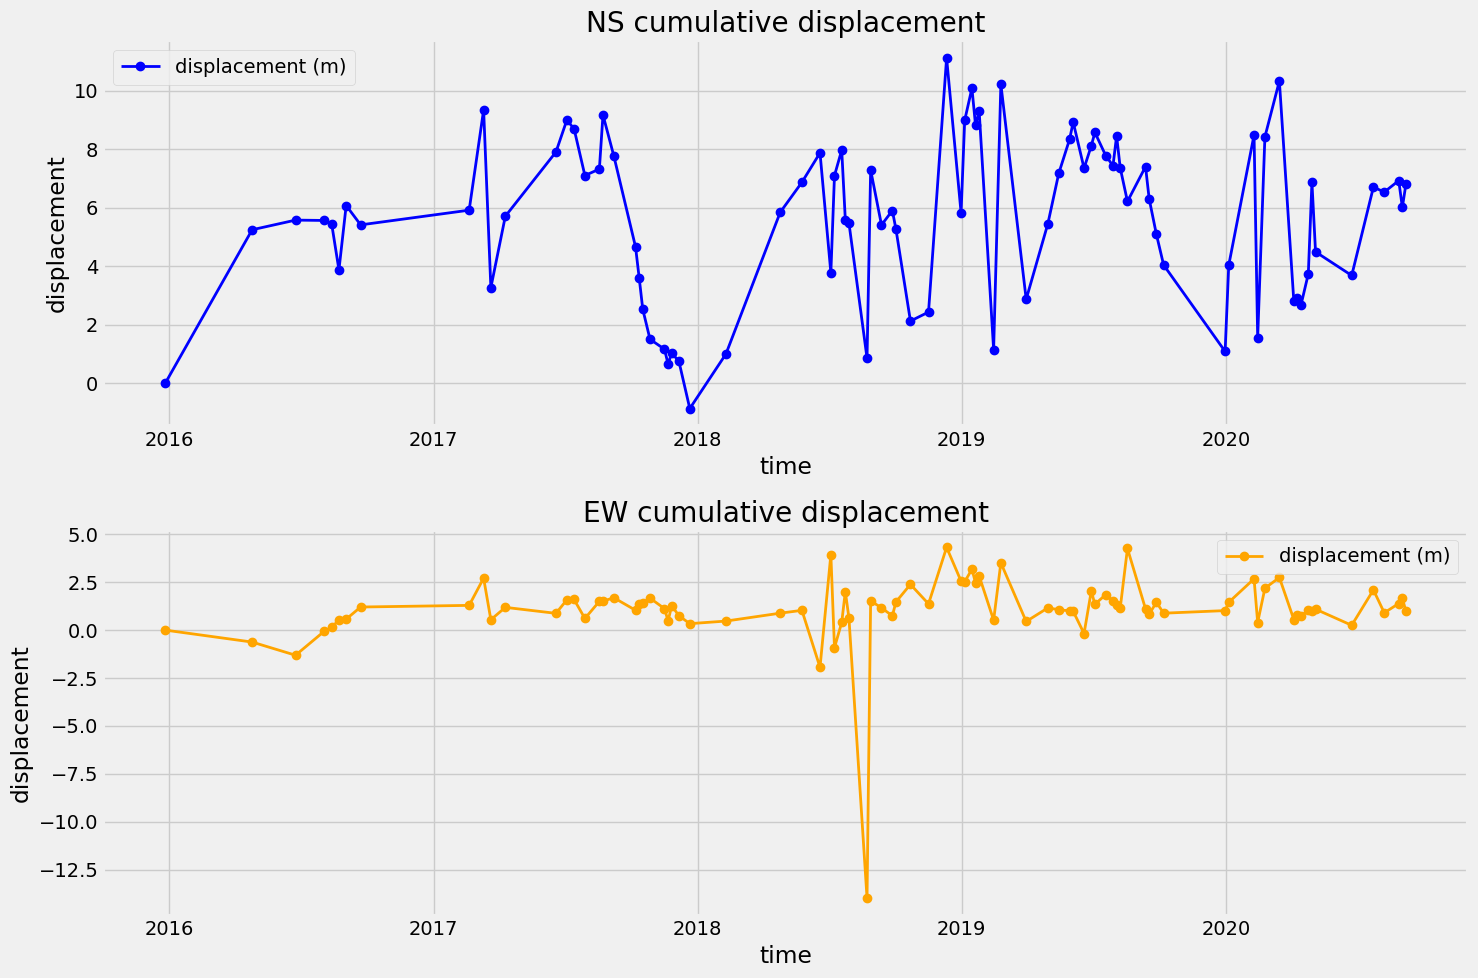

In [81]:
m = 47521
index = Data.non_filtered_ids
#viz.plot_disp_ns_ew(Data.pixels[n].ns , Data.pixels[n].ew)
Visualization().plot_disp_ns_ew(Data.pixels[m].ns, Data.pixels[m].ew)

In [21]:
def compute_vel(ns_component, ew_component):
    return math.sqrt(ns_component * ns_component + ew_component * ew_component)

def compute_inst_vels(series):
    with multiprocessing.Pool(4) as p:
        results = p.map(TimeSerie().compute_inst_vel, series)
        return results
    
def compute_velocities2(pixels):
    velocities = []
    non_filtered_ids = np.arange(10)
    ns_vels = compute_inst_vels([pixels[n].ns for n in non_filtered_ids])
    ew_vels = compute_inst_vels([pixels[n].ew for n in non_filtered_ids])
    for i in range(len(ns_vels)):
        vels = []
        column = ns_vels[0].columns[0]
        for ns_vel, ew_vel in zip(ns_vels[i][column], ew_vels[i][column]):
            vels.append(compute_vel(ns_vel, ew_vel))
        df = pd.DataFrame(vels, index=ns_vels[0].index, columns=['magnitude'])
        velocities.append(df)
    return velocities

In [514]:
def get_days(index):
    days = []
    dates = index
    for i in range(len(dates)):
        days.append(abs((dates[0] - dates[i]).days ))
    return days

def compute_pearson_coef(serie, index):
    return stats.pearsonr(np.squeeze(serie.values), get_days(index))

In [1]:
def prepare(serie):
    # transformer les index en durée pour pouvoir effectuer une regression linéaire
    X = np.array([abs((serie.index[0] - serie.index[n]).days) for n in range(len(serie.index))]).reshape(-1,1)
    # extraire la cible
    y = StandardScaler().fit_transform(serie)
    return X, y

def compute_linear_reg_pval(serie):
    # extraire X et y
    X, y = prepare(serie)
    # calculer la p-value de la regression lineaire
    _, pval = f_regression(X,y.ravel())
    return  pval[0]

In [503]:

p = compute_linear_reg_pval(Data.pixels[n].ew)
print(p)
if p < 0.05: 
    print('regression significative')
else:
    print('regression non significative ')

0.040941677134852125
regression significative


In [136]:
def smooth(s, ampl):
        serie = s.copy()
        std = math.sqrt(serie.var())
        for i in range(len(serie)):
            if abs(serie.iloc[i].displacement) > ampl*std:
                serie.iloc[i, serie.columns.get_loc('displacement')]= np.nan
        return serie.interpolate(limit_direction='both', inplace=False)

In [88]:
def is_stationary(serie, freq='Y', alpha=0.05):
    resampled = serie.resample(freq)
    interpolated = resampled.interpolate(method='linear')
    return interpolated

In [119]:
# Example of the Analysis of Variance Test
from scipy.stats import f_oneway 
#serie = Data.pixels[n].ns.rolling().var().interpolate(limit_direction='both', inplace=True)
 #data1 = np.squeeze(Data.pixels[n].ns.values)
data1 = np.squeeze(Data.pixels[n].ew.values)
mean = np.mean(data1)
data2 = np.full(len(data1), mean)
stat, p = f_oneway(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=0.000, p=1.000
Probably the same distribution


In [295]:
#Data = DataFromImageCorrelation(RASTER_FOLDER_PATH, DEM_FILENAME, geo.head(n), df_ns_ts[:n], df_ew_ts[:n])
Data = DataFromImageCorrelation(pixels, raster_folder_path, dem_filename)

# Analyse des filtres

# Filtre vitesse & regression linéaire

In [ ]:
factors = [1.5, 2, 2.5, 3]
for factor in factors:
    print('start')
    Data.test_filter(factor)
    print('end')
    Visualization().generate_kml_file3(Data.non_filtered_ids, latitudes, longitudes, 'yellow', filename='filtre_vel_reg_factor=' + str(factor))
    print('k')

## Filtre Vitesse

In [18]:
def plot_raster(raster, cmap='gray'):
    values = raster.GetRasterBand(1).ReadAsArray()
    plt.figure()
    plt.imshow(values, cmap = cmap)
    plt.colorbar()
    plt.show()
    
def compute_slope_azimuth_map(dem_path, output_name):
    dem = gdal.Open(dem_path)
    slope_map = gdal.DEMProcessing('rasters/' + output_name + '.tif', dem, 'aspect', computeEdges = True, trigonometric=False)

In [19]:
dem_path = 'rasters/31TGK_copernicus_dem.tif'
compute_slope_azimuth_map(dem_path, 'slope_azimuth_map')

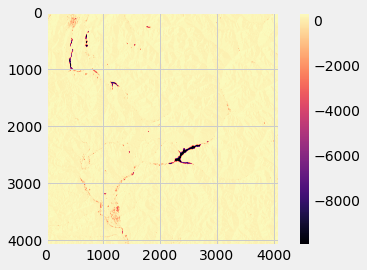

In [477]:
plt.rcParams["axes.grid"] = True
path = 'rasters/MM_TIO_Magnitude_31TGK_20151227_to_20200906.tif'
slope_azimuth_path = 'rasters/slope_azimuth_map.tif'
slope_azimuth_raster = gdal.Open(slope_azimuth_path)
#magnitudes_map = gdal.Open(path)
#slope_map = gdal.DEMProcessing('rasters/slope_map.tif', dem, 'slope', computeEdges = True)
plot_raster(slope_azimuth_raster, cmap='magma')

In [64]:
def extract_value_from_raster(lat, lon, file='rasters/slope_azimuth_map.tif', ref='wgs84'):
        val = os.popen('gdallocationinfo -valonly -%s %s %f %f' % (ref, file, lat, lon)).read()
        if len(val) == 0:
            raise ValueError('La valeur est non valide !')
        return  float(val)
ref = 'wgs84'
file = 'rasters/slope_azimuth_map.tif'
#lat = 6.662360
#lon = 44.394169

#val = os.popen('gdallocationinfo -valonly -%s %s %f %f' % (ref, file, lat, lon)).read()
#val = extract_value_from_raster(file, ref, lat, lon)

In [ ]:
azimuths = []
for lat, lon in zip(latitudes, longitudes):
    val = extract_value_from_raster(file, ref, lat, lon)
    azimuths.append(val)

## Filtre azimuth

In [81]:
'''
atan2 renvoie une valeur dans [-pi, pi]
l'azimut calculé par gdal est  compris en entre 0 et 360 degrés.
il faut donc rajouter 2pi à atan2 lorsque sa valeur est négative sachant que atan2
renvoie une valeur comprise entre -pi et pi
'''

"\natan2 renvoie une valeur dans [-pi, pi]\nl'azimut calculé par gdal est  compris en entre 0 et 360 degrés.\nil faut donc rajouter 2pi à atan2 lorsque sa valeur est négative sachant que atan2\nrenvoie une valeur comprise entre -pi et pi\n"

In [82]:
 def plot_(liste, azimuths, pixels_azimuths,  name):
         
        fig, ax = plt.subplots(2, 1, figsize=(15,10))
        
        for n in range(len(liste)):
            ax[n].plot(azimuths[n], color='blue', label='displacement (m)', marker='o', linewidth=2)
            ax[n].set_title('NS cumulative displacement')
            ax[n].set_xlabel('time')
            ax[n].set_ylabel('azimuth (°)')
            ax[n].axhline(y=pixels_azimuths[n], color='r', label='pixel azimuth', linestyle='-', linewidth=1)
        
        plt.savefig(name + '.png')
        fig.tight_layout()
        plt.show()

In [90]:
import subprocess

cmd1 = [
        "gdaltindex",
        "rasters/shapefiles/dem_lavalette.shp",
        "rasters/Lavalette/MM_TIO_Magnitude_31TGK_20151227_to_20200906.tif"
        ]
subprocess.run(cmd1)

CompletedProcess(args=['gdaltindex', 'rasters/shapefiles/dem_lavalette.shp', 'rasters/Lavalette/MM_TIO_Magnitude_31TGK_20151227_to_20200906.tif'], returncode=0)

In [26]:
dem = gdal.Open("rasters/mnt/31TGK_copernicus_dem.tif")

In [82]:
# create DEM for Lavalette area
def cut_raster(ds, raster_output, shapefile_output, xres, yres):
    small_dem = gdal.Warp(raster_output, ds, cutlineDSName=shapefile_output, cropToCutline=True, dstNodata=np.nan, xRes=xres, yRes=yres, resampleAlg='cubic')
    small_dem = None

def compute_slope_azimuth_map(dem_path, output_name):
    dem = gdal.Open(dem_path)
    slope_map = gdal.DEMProcessing(output_name + '.tif', dem, 'aspect', computeEdges = True, trigonometric=False)
    slope_map = None
    dem = None

In [109]:
xres, yres = rasterio.open("rasters/Lavalette/MM_TIO_Magnitude_31TGK_20151227_to_20200906.tif").res
cut_raster(dem, 'rasters/mnt/dem_lavallette.tif', 'rasters/shapefiles/dem_lavalette.shp', xres, yres)

In [110]:
# compute slope azimuth map
compute_slope_azimuth_map('rasters/mnt/dem_lavallette.tif', 'rasters/azimuths/slope_azimuths_lavalette')

In [108]:
# open azimuth file
gdal_azimuths_lavalette_raster = rasterio.open('rasters/azimuths/slope_azimuths_lavalette.tif')

In [111]:
gdal_azimuths_lavalette_raster.read(1)

array([[  206.56505 ,   251.56505 ,   260.53766 , ...,   184.76364 ,
          180.      , -9999.      ],
       [  225.      ,   251.56505 ,   259.8245  , ...,   184.76364 ,
          180.      , -9999.      ],
       [  219.80557 ,   250.20113 ,   260.31122 , ...,   184.76364 ,
          180.      , -9999.      ],
       ...,
       [  153.43495 ,   128.29016 ,   115.70995 , ...,   154.29004 ,
          171.8699  , -9999.      ],
       [  153.43495 ,   131.42366 ,   117.474434, ...,   153.43495 ,
          166.60751 , -9999.      ],
       [  165.96375 ,   135.      ,   123.69006 , ...,   155.22485 ,
          167.47119 , -9999.      ]], dtype=float32)

In [112]:
gdal_azimuths_lavalette_raster

<open DatasetReader name='rasters/azimuths/slope_azimuths_lavalette.tif' mode='r'>

In [96]:
epsg_code = '32631'
proj = Proj("epsg:" + epsg_code, preserve_units=False)
x, y = gdal_azimuths_lavalette_raster.transform * (1, 1)
lat, lon = proj(x, y, inverse=True)
print(lat, lon)

A = extract_value_from_raster(lat, lon, 'rasters/azimuths/slope_azimuths_lavalette.tif')
print(A)

6.628042184810065 44.4219127157047
206.565048217773


In [89]:
gdal_azimuths_lavalette_raster.read(1)[1,1]

251.56505

In [93]:
def extract_value_from_raster(lat, lon, file, ref='wgs84'):
        val = os.popen('gdallocationinfo -valonly -%s %s %f %f' % (ref, file, lat, lon)).read()
        if len(val) == 0:
            raise ValueError('La valeur est non valide !')
        return  float(val)

In [97]:
from multiprocessing import Pool
azimuths = None
with Pool(4) as p:
    azimuths = p.map(compute_azimuth_serie4, pixels[20000:30000])

NameError: name 'compute_azimuth_serie4' is not defined

In [158]:
pixel_azimuths = None
with Pool(4) as p:
    pixel_azimuths = p.starmap(extract_value_from_raster, [(pixel.lat, pixel.lon) for pixel in pixels[20000:30000]])

In [36]:
liste = [21791, 35193, 36936, 38989, 44605, 43999, 44011, 43442, 48357, 50395, 46907, 48651]
signals = [34900, 28490, 37520, 36659, 42193, 30546, 34313, 38980, 30237, 33451, 22367, 24713, 22961, 25887, 28509]
non_signals = [47521, 40813, 47557, 47841, 49882, 43172, 48141, 41143, 45777, 44317,5842, 42256, 44879, 39398 ,46649]

pixels_azimuths, azimuths = [], []
for n in non_signals:
    pixel_azimuth = extract_value_from_raster(pixels[n].lat, pixels[n].lon, file)
    pixels_azimuths.append(pixel_azimuth)
    azimuths.append(compute_azimuth_serie4(pixels[n]))
    
#Visualization().generate_km_file_testing(pixels, [signals, non_signals], ['green', 'yellow'])

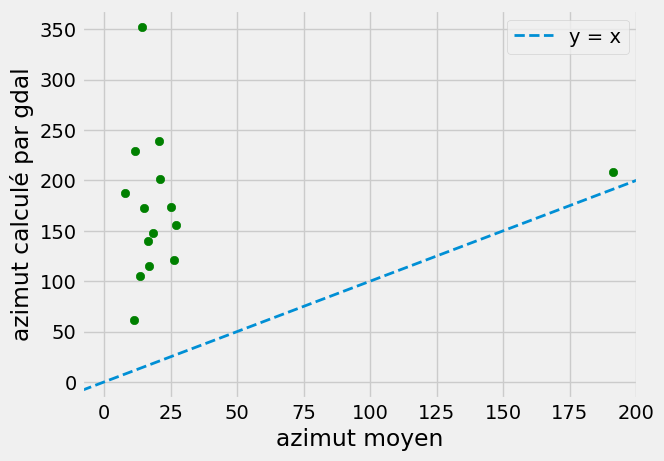

In [52]:
plt.scatter(azimuths, pixels_azimuths,  color='g')
plt.axline((1, 1), slope=1, label='y = x', linestyle='--', linewidth=2)
plt.xlabel('azimut moyen')
plt.ylabel('azimut calculé par gdal')
plt.legend(loc='best')
#plt.savefig('non_landslide_azimuth.jpg')
plt.show()

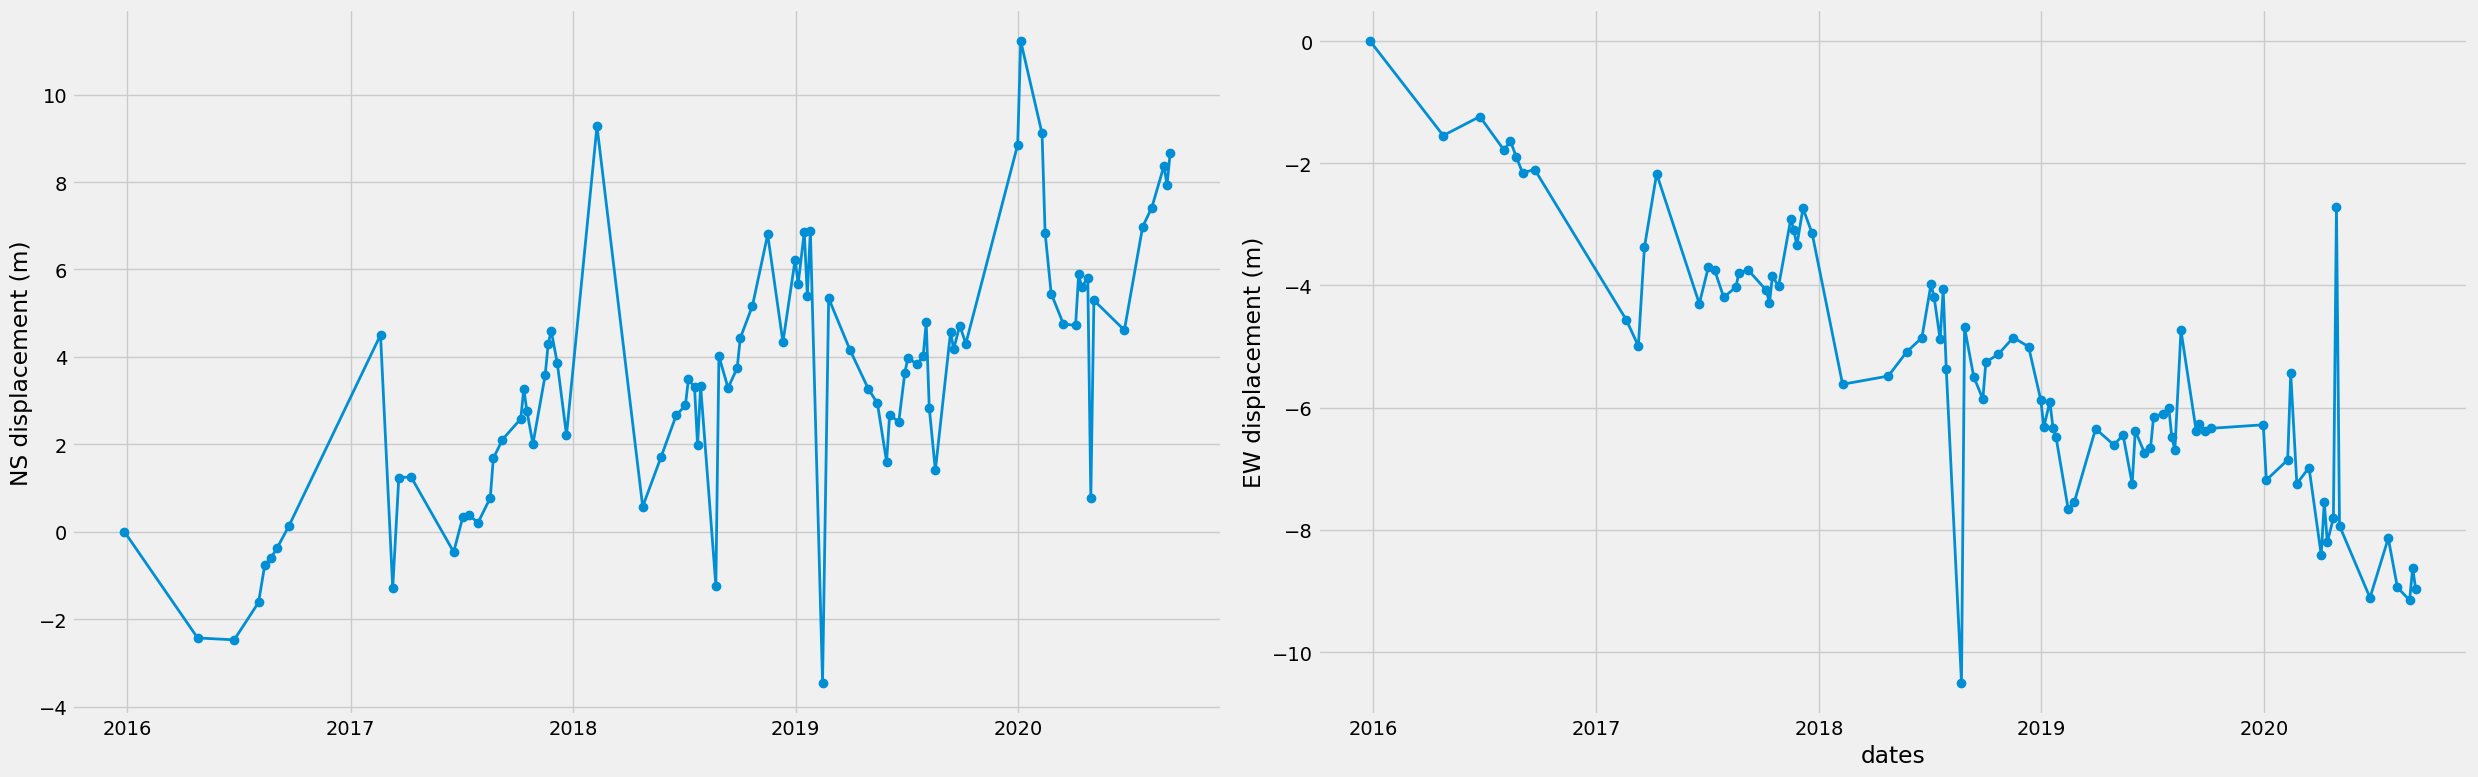

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(25,8))
axs[0].plot(pixels[signals[0]].ns, marker='o', linestyle='-', linewidth=2)
axs[0].set_ylabel('NS displacement (m)')
axs[1].plot(pixels[signals[0]].ew, marker='o', linestyle='-', linewidth=2)
axs[1].set_ylabel('EW displacement (m)')
plt.xlabel('dates')
plt.tight_layout()
plt.savefig('disp_landslide.png')
plt.show()

In [652]:
def plot2(azimuths, pix_azimuths, output, ncols=2, colormap='tab20', figsize=(25,15)):
    n = len(azimuths)
    nrows = int(n / ncols) if n % ncols == 0 else int(math.ceil(n / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    cmap = plt.get_cmap(colormap)
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    for i in range(n):
        axes[int(i / ncols), i % ncols].plot(azimuths[i], color=colors[i])
        axes[int(i / ncols), i % ncols].axhline(y=pix_azimuths[i], color='black', label='pixel azimuth', linestyle='-', linewidth=1)
        axes[int(i / ncols), i % ncols].set_title('gdal azimuth = ' + str(pix_azimuths[i]) + '°')
    plt.savefig(output + '.png')
    fig.tight_layout()
    plt.show()
    
def plot_test(pixels, output, ncols=2, colormap='tab20', figsize=(25,15)):
    n = len(azimuths)
    nrows = int(n / ncols) if n % ncols == 0 else int(math.ceil(n / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    cmap = plt.get_cmap(colormap)
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    for i in range(n):
        axes[int(i / ncols), i % ncols].plot(pixels[i].ns, color=colors[i])
    plt.savefig(output + '.png')
    fig.tight_layout()
    plt.show()

In [85]:
n = 100000
# 29000, 29317(bien aligné), 77297(bien aligné), 25459
azimuths = np.array(compute_azimuth_serie(pixels[n]))
azimuth = extract_value_from_raster(file, ref, pixels[n].lat, pixels[n].lon)
plt.plot(np.array(azimuths), label='displacement azimuth', marker='o', linewidth=1)
plt.axhline(y=azimuth, color='r', label='pixel azimuth', linestyle='-', linewidth=1)
plt.ylabel('azimuth (°)')
plt.show()

IndexError: list index out of range

In [1076]:
az = compute_azimuth3(file, ref, pixels[n])

## Filtre Coherence

In [29]:
latitudes = [pixel.lat for pixel in pixels]
longitudes = [pixel.lon for pixel in pixels]

In [68]:
ns_coherence = df_ns['Coer'].values
ew_coherence = df_ew['Coer'].values
ns_coherence_std = np.std(ns_coherence)
ew_coherence_std = np.std(ew_coherence)

In [51]:
quantiles = [0.25, 0.5, 0.75]
for quantile in quantiles:
    ns_qt = np.quantile(ns_coherence, quantile)
    ew_qt = np.quantile(ew_coherence, quantile)
    ns_mask = np.where(ns_coherence > ns_qt, True, False)
    ew_mask = np.where(ew_coherence > ew_qt, True, False)
    mask = np.logical_and(ns_mask, ew_mask)
    viz = Visualization()
    viz.generate_kml_file(mask, latitudes, longitudes, 'yellow', filename='filtre_coherence_quantile=' + str(quantile))

## Filtre cohérence vectorielle

In [475]:
from numpy import linalg as LA
def compute_vector_coherence(pixel):
        diff_ns = np.diff(np.squeeze(pixel.ns.values))
        diff_ew = np.diff(np.squeeze(pixel.ew.values))
        num = self.compute_norm(np.sum(diff_ns), np.sum(diff_ew))
        den = np.sum(LAiff_ns, diff_ew)
        return num / den 

In [488]:
from numpy import linalg as LA

def test(x,y):
    return np.sqrt(x * x + y * y)

def compute_vector_coherence(pixel):
        ns = np.diff(pixel.ns.values.flatten())
        ew = np.diff(pixel.ew.values.flatten())
        num = LA.norm([np.sum(ns), np.sum(ew)])
        den = np.sum([test(x,y) for x, y in zip(ns, ew)])
        return num / den

In [ ]:
cutoffs = [0.4, 0.6, 0.7, 0.8]
vfunc = np.vectorize(compute_vector_coherence)
vector_coherence = vfunc(pixels)
for cutoff in cutoffs:
    mask = np.where(vector_coherence > cutoff, True, False)
    Visualization().generate_kml_file(mask, latitudes, longitudes, 'yellow', filename='filtre_vect_coher_cutoff=' + str(cutoff))

#  Calcul des profils de vitesse

In [116]:
factors = [1.5, 2, 2.5, 3]
latitudes = [pixel.lat for pixel in pixels]
longitudes = [pixel.lon for pixel in pixels]
for factor in factors:
    mask = Data.debug_filter_by(factor=factor)
    viz = Visualization()
    viz.generate_kml_file(mask, latitudes, longitudes, 'yellow', filename='filtre_vitesse_sigma=' + str(factor))

In [304]:
Data.filter_by(factor=2)
X = Data.non_filtered_ids

[ True  True  True ...  True  True  True] 87016


In [307]:
Data.filter_by5(factor=2)
Y = Data.non_filtered_ids

In [302]:
len(Data.non_filtered_ids)

70543

In [289]:
#Data.compute_velocities(min_slope=5, ampl=2, ampl_disp=2)
Data.compute_velocities2()

Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/eost-user/miniconda3/envs/sdsc_stage/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/eost-user/miniconda3/envs/sdsc_stage/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eost-user/miniconda3/envs/sdsc_stage/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/eost-user/miniconda3/envs/sdsc_stage/lib/python3.9/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "<ipython-input-52-5763069ba2fe>", line 126, in compute_inst_vel
    duration = (serie.index[i+1] - serie.index[i-1]).days
  File "/home/eost-user/miniconda3/envs/sdsc_stage/lib/python3.9/site-packages/pandas/core/indexes/extension.py", line 238, in __getitem__
  

KeyboardInterrupt: 

# Clustering des profils de vitesse 

In [85]:
import simplekml
clustering = Clustering(Data, option=0)
clustering.cluster(min_cluster_size=30, min_samples=None, precomputed=False)
#clustering.visualize()
#clustering.generate_kml_file() 

/home/eost-user/miniconda3/lib/python3.9/site-packages/hdbscan/hdbscan_.py:217: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  warn('Cannot generate Minimum Spanning Tree; '


In [86]:
clustering.generate_kml_file2()

In [953]:
from math import sin, cos, sqrt, atan2, radians

# le resultat est en mètre
def compute_distance(lat1, lon1, lat2, lon2, R=6371000):
    
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)
    
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return  R * c

def compute_distance_matrix(latitudes, longitudes):
    size = len(latitudes)
    distances_matrix = np.zeros(shape=(size, size))
    scaler = StandardScaler()
    for n in range(size):
        for m in range(n , size):
            distances_matrix[n, m] = compute_distance(latitudes[n], longitudes[n], latitudes[m], longitudes[m])
            distances_matrix[m, m] = distances_matrix[n, m]
    return distances_matrix

In [1001]:
from math import radians
clustering = pd.read_csv('clustering_result.csv')
# conversion des degrées en radian 
X = clustering[['Lat', 'Lon']].applymap(radians)

In [1005]:
latitudes = clustering['Lat'].values
longitudes = clustering['Lon'].values

In [891]:
from sklearn.cluster import DBSCAN

In [1004]:
clustering_ = DBSCAN(eps=10, min_samples=5,  metric='haversine').fit(X)
labels = clustering_.labels_

In [ ]:
colors = [plt.cm.Spectral(n)
          for n in np.linspace(0, 1, len(labels))]

for label, color in zip(labels, colors):
    class_mask = (labels == label)
    xx = latitudes[class_mask]
    yy = longitudes[class_mask]
    plt.plot(xx , yy, 'o', markerfacecolor=tuple(color), markeredgecolor='k', markersize=6)
plt.show()

# Analyse visuelle des clusters

In [510]:
def compute_adfuller(serie):
    adf_result = adfuller(serie)
    adf_output = pd.Series(adf_result[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in adf_result[4].items():
        adf_output['Critical Value (%s)'%(key)] = value
    return adf_output[1]

In [ ]:
#n= 390
viz = Visualization()
index = Data.non_filtered_ids
#viz.plot_disp_ns_ew(Data.pixels[n].ns , Data.pixels[n].ew)
viz.plot_disp_vel(Data.pixels[n].ns, Data.pixels[n].ew, Data.velocities[Data.non_filtered_ids.index(n)])

# Analyse en composantes principales

# Clustering des champs de vitesses

In [2]:
import rasterio
from pyproj import Proj

In [3]:
velocities_path = 'rasters/mpic/'
mean_velocity_ns_filename = 'MM_Mean_velocity_NS_31TGK_20151227_to_20200906.tif'
mean_velocity_ew_filename = 'MM_Mean_velocity_EW_31TGK_20151227_to_20200906.tif'
analysis_quality_map_filename = 'MM_Analysis_quality_map_1126_lay_31TGK_20151227_to_20200906.tif'
vector_coherence_filename = 'MM_Vector_coherence_31TGK_20151227_to_20200906.tif'
mean_velocity_magnitude_filename = 'MM_Mean_veloc_magnitude_31TGK_20151227_to_20200906.tif'

In [5]:
ns_velocities_rasterio = rasterio.open(velocities_path + mean_velocity_ns_filename)
ns_velocities_raster = gdal.Open(velocities_path + mean_velocity_ns_filename)
ew_velocities_raster = gdal.Open(velocities_path + mean_velocity_ew_filename)
analysis_quality_raster = gdal.Open(velocities_path + analysis_quality_map_filename)
vector_coherence_raster = gdal.Open(velocities_path + vector_coherence_filename)
velocity_magnitude_raster = gdal.Open(velocities_path + mean_velocity_magnitude_filename)

In [6]:
ns_velocities = ns_velocities_raster.GetRasterBand(1).ReadAsArray()
ew_velocities = ew_velocities_raster.GetRasterBand(1).ReadAsArray()
analysis_quality = analysis_quality_raster.GetRasterBand(1).ReadAsArray()
vector_coherence = vector_coherence_raster.GetRasterBand(1).ReadAsArray()
velocity_magnitude_g = velocity_magnitude_raster.GetRasterBand(1).ReadAsArray()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize =(10, 5), tight_layout = True)
axs[0].hist(velocity_magnitude.flatten(), color='g', label='velocity magnitude')
axs[0].legend(loc='best')
axs[1].hist(vector_coherence.flatten(), color='r', label='vector coherence')
axs[1].legend(loc='best')
plt.show()

In [7]:
def convert_to_lat_lon(x, y, epsg_code='32631'):
    proj = Proj("epsg:" + epsg_code, preserve_units=False)
    return p(x, y, inverse=True)

def compute_lat_lon_matrix(raster):
    latitudes, longitudes = [], []
    for i in range(raster.height):
        for j in range(raster.width):
            utms = raster.transform * (i, j)
            lat, lon = convert_to_lat_lon(utms[0], utms[1])
            latitudes.append(lat)
            longitudes.append(lon)
    return np.array(latitudes).reshape(raster.height, raster.width), np.array(longitudes).reshape(raster.height, raster.width)

def generate_kml_file(latitudes, longitudes, color, filename):
    
    url = 'http://maps.google.com/mapfiles/ms/micons/'
    kml = simplekml.Kml()
    for latitude, longitude in zip(latitudes, longitudes):
        pnt = kml.newpoint(description='', coords=[(latitude, longitude)])
        pnt.iconstyle.icon.href = url + color + '-dot.png'
    kml.save(filename + '.kml')
   

In [ ]:
chunk_size = 50000
chunk_num = 0

chunks = pd.read_csv('new_zone_lat_lon.csv', chunksize=chunk_size)
for chunk in chunks:
    chunk.to_csv('geo_chunk_' + str(chunk_num) + '.csv', index=False)
    print(chunk_num)
    chunk_num += 1

In [8]:
inpath = 'rasters/mpic/'
input_filenames = [mean_velocity_ns_filename, mean_velocity_ew_filename, mean_velocity_magnitude_filename, vector_coherence_filename]
output_filenames  = ['velocity_NS', 'velocity_EW', 'veloc_magnitude', 'Vector_coherence']

In [40]:
class Raster():
    
    def __init__(self):
        pass
    
    def split_raster2(self, in_path, input_filename, output_filename, x_pixel_step, y_pixel_step):

        ds = gdal.Open(in_path + input_filename)
        xsize = ds.RasterXSize
        ysize = ds.RasterYSize
        
        n_count = 0
        for i in range(0, xsize, x_pixel_step):
            for j in range(0, ysize, y_pixel_step):
                print(i,j, n_count)
                com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + ", " + str(x_pixel_step) + ", " + str(y_pixel_step) + " " + str(in_path) + str(input_filename) + " " + str(in_path) + 'split_' + str(output_filename) + '_' + str(n_count) + ".tif"
                os.system(com_string)
                n_count += 1
    
    def split_raster(self, in_path, input_filename, output_filename, n_split=5):

        ds = gdal.Open(in_path + input_filename)
        band = ds.GetRasterBand(1)
        xsize = band.XSize
        ysize = band.YSize

        tile_size_x = math.ceil(xsize / n_split)
        tile_size_y = ysize # on découpe le raster verticalement !
        n_count = 0
        for i in range(0, xsize, tile_size_x):
            for j in range(0, ysize, tile_size_y):
                com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " + str(in_path) + str(input_filename) + " " + str(in_path) + 'split_' + str(output_filename) + '_' + str(n_count) + ".tif"
                os.system(com_string)
                n_count += 1
        ds = None
        
    def split_rasters2(self, in_path, input_filenames, output_filenames,  x_pixel_step=3323, y_pixel_step=371):
        for input_filename, output_filename in zip(input_filenames, output_filenames):
            self.split_raster2(in_path, input_filename, output_filename, x_pixel_step=x_pixel_step, y_pixel_step=y_pixel_step)

    def split_rasters(self, in_path, input_filenames, output_filenames, n_split=5):
        for input_filename, output_filename in zip(input_filenames, output_filenames):
            self.split_raster(in_path, input_filename, output_filename, n_split=n_split)
        
    def load_split_rasters(self, in_path, output_filenames, n_splits=5):
        rasters, filenames_to_load = [], []
        for output_filename in output_filenames:
            filenames_to_load.append(['split_' + output_filename + '_' + str(n) + '.tif' for n in range(n_splits)])
        for n in range(n_splits):
            files = [rasterio.open(in_path + files[n]) for files in filenames_to_load]
            rasters.append(tuple(files))
        return rasters
    
    def getBoxBounds(self, raster):
        min_y = raster.bounds.bottom
        max_y = raster.bounds.top
        min_x = raster.bounds.left
        max_x = raster.bounds.right
        min_lat, min_lon = proj(min_x, min_y, inverse=True)
        max_lat, max_lon = proj(max_x, max_y, inverse=True)
        return (min_x, min_y, max_x, max_y), (min_lon, min_lat, max_lon, max_lat)
    
    def compute_slope_azimuth_map(self, dem_path, output_name):
        dem = gdal.Open(dem_path)
        slope_map = gdal.DEMProcessing('rasters/azimuths/' + output_name + '.tif', dem, 'aspect', computeEdges = True, trigonometric=False)

    def extract_value_from_raster(self, lat, lon, file, ref='wgs84'):
        val = os.popen('gdallocationinfo -valonly -%s %s %f %f' % (ref, file, lat, lon)).read()
        if len(val) == 0:
            raise ValueError('La valeur est non valide !')
        return float(val)
    
    def generate_shapefile(self, raster_in_path, shapefile_out_path):
        cmd = ["gdaltindex", shapefile_out_path, raster_in_path]
        subprocess.run(cmd1)
        
    def get_raster_resolution(self, raster):
        xres, yres = rasterio.open(raster).res
        return xres, yres
    
    def cut_raster(raster_output, shapefile_output, xres, yres):
        small_raster = gdal.Warp(raster_output, ds, cutlineDSName=shapefile_output, cropToCutline=True, dstNodata=np.nan, xRes=pxsz, yRes=pysz, resampleAlg='cubic')
        small_raster = None
    
    def split_raster3(self, in_path, input_filename, output_filename, x_pixel_step, y_pixel_step):
        print(inpath + input_filename)
        raster = gdal.Open(in_path + input_filename)
        print(raster)
        gt = raster.GetGeoTransform()
        
        xmin = gt[0]
        ymax = gt[3]
        res = gt[1]
        xlen = res * raster.RasterXSize
        ylen = res * raster.RasterXSize

        xsize = x_pixel_step * res
        ysize = y_pixel_step * res

        xnsplits = int(raster.RasterXSize / x_pixel_step)
        ynsplits = int(raster.RasterYSize / y_pixel_step)

        xsteps = [xmin + xsize * i for i in range(xnsplits + 1)]
        ysteps = [ymax - ysize * i for i in range(ynsplits + 1)]
    
        n_count = 0
        for i in range(xnsplits):
            for j in range(ynsplits):
                xmin_ = xsteps[i]
                xmax_ = xsteps[i + 1]
                ymax_ = ysteps[j]
                ymin_ = ysteps[j + 1]
                print(xmin_, xmax_, ymin_, ymax_)
                #gdal.Warp(raster_filename + str(i) + str(j) + '.tif', raster, outputBounds=(xmin_, xmax_, ymin_, ymax_), dstNodata=-9999)
                gdal.Translate(inpath + 'split_' + output_filename + '_' + str(n_count) + '.tif', raster, projWin=(xmin_, ymax_, xmax_, ymin_))
                n_count += 1
        raster = None
        
                
    def split_rasters3(self, in_path, input_filenames, output_filenames,  x_pixel_step=3323, y_pixel_step=371):
        for input_filename, output_filename in zip(input_filenames, output_filenames):
            self.split_raster3(in_path, input_filename, output_filename, x_pixel_step, y_pixel_step)

In [10]:
def split_raster(in_path, input_filename, output_filename, xpixels=3323, ypixels=371):

        ds = gdal.Open(in_path + input_filename)
        xsize = ds.RasterXSize
        ysize = ds.RasterYSize
        
        n_count = 0
        for i in range(0, xsize, xpixels):
            for j in range(0, ysize, ypixels):
                com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + ", " + str(xpixels) + ", " + str(ypixels) + " " + str(in_path) + str(input_filename) + " " + str(in_path) + 'split_' + str(output_filename) + '_' + str(n_count) + ".tif"
                os.system(com_string)
                n_count += 1

In [25]:
split_raster('rasters/mpic/','MM_Mean_veloc_magnitude_31TGK_20151227_to_20200906.tif', 'rasters/test')

In [11]:
parent_dir = 'rasters/mpic/'
directory = 'Zone'
path = os.path.join(parent_dir, directory)
os.mkdir(path)

In [15]:
cut_raster2('rasters/mpic/MM_Mean_veloc_magnitude_31TGK_20151227_to_20200906.tif')

1 5
773780.0 807010.0 4927690.0 4931400.0
773780.0 807010.0 4923980.0 4927690.0
773780.0 807010.0 4920270.0 4923980.0
773780.0 807010.0 4916560.0 4920270.0
773780.0 807010.0 4912850.0 4916560.0


In [56]:
Raster().getBoxBounds(rasterio.open('rasters/mpic/MM_Mean_veloc_magnitude_31TGK_20151227_to_20200906.tif'))

((773780.0, 4912850.0, 807010.0, 4931400.0),
 (44.31730415383845, 6.433116181338787, 44.470657774975344, 6.859877850733266))

In [47]:
Raster().split_rasters3(inpath, input_filenames, output_filenames)

rasters/mpic/MM_Mean_velocity_NS_31TGK_20151227_to_20200906.tif
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7facaee721b0> >
773780.0 807010.0 4927690.0 4931400.0
773780.0 807010.0 4923980.0 4927690.0
773780.0 807010.0 4920270.0 4923980.0
773780.0 807010.0 4916560.0 4920270.0
773780.0 807010.0 4912850.0 4916560.0
rasters/mpic/MM_Mean_velocity_EW_31TGK_20151227_to_20200906.tif
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7facaec497e0> >
773780.0 807010.0 4927690.0 4931400.0
773780.0 807010.0 4923980.0 4927690.0
773780.0 807010.0 4920270.0 4923980.0
773780.0 807010.0 4916560.0 4920270.0
773780.0 807010.0 4912850.0 4916560.0
rasters/mpic/MM_Mean_veloc_magnitude_31TGK_20151227_to_20200906.tif
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7facaec497e0> >
773780.0 807010.0 4927690.0 4931400.0
773780.0 807010.0 4923980.0 4927690.0
773780.0 807010.0 4920270.0 4923980.0
773780.0 807010.0 4916560.0 

In [48]:
rasters = Raster().load_split_rasters(inpath, output_filenames)

In [52]:
sigma_mean_vel = np.nanstd(velocity_magnitude_g)

In [59]:
epsg_code = '32631'
proj = Proj("epsg:" + epsg_code, preserve_units=False)
# 1, 1.5, 2, 2.5, 3
factors = np.array([0, 1, 1.5, 2, 2.5, 3])
# 0.2, 0.4, 0.5, 0.6, 0.7
coherences = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
# extract rasters 40, 30, 35
mean_ns_velocity_r, mean_ew_velocity_r, velocity_magnitude_r, coherence_r = rasters[2]
# extract rasters as array and reshape them
mean_ns_velocity = mean_ns_velocity_r.read(1)
# East-West velocities
mean_ew_velocity = mean_ew_velocity_r.read(1)
# velocity magnitude
velocity_magnitude = velocity_magnitude_r.read(1)
# coherence
coherence = coherence_r.read(1)

for factor in [0.0]:
    for cor in [0.0]:
        latitudes, longitudes = [], []
        mask = (velocity_magnitude > factor * sigma_mean_vel) & (coherence > cor)
        mask_index = np.where(mask)
        print(factor, cor)
        for i, j in zip(mask_index[0], mask_index[1]):
            x, y = velocity_magnitude_r.transform * (i, j)
            lat, lon = proj(x, y, inverse=True)
            latitudes.append(lat)
            longitudes.append(lon)
        generate_kml_file(latitudes, longitudes, 'yellow', filename='factor=' + str(factor) + '_coherence=' + str(cor))

0.0 0.0


In [130]:
def filtre_azimuth(projection, tols, raster, azimuths, gdal_azimuths):
    results = []
    for tol in tols:
        print(tol)
        mask = (azimuths > gdal_azimuths - tol) & ( azimuths < gdal_azimuths + tol )
        mask_index = np.where(mask)
        latitudes, longitudes = [], []
        for i, j in zip(mask_index[0], mask_index[1]):
            x, y  = raster.transform * (i, j)
            lat, lon = projection(x, y, inverse=True)
            latitudes.append(lat)
            longitudes.append(lon)
            print(lat, lon)
        #results.append((latitudes, longitudes))
        print('tol=%d, percentage=%f'%(tol, len(latitudes)))
        generate_kml_file(latitudes, longitudes, 'yellow', filename='tol=' + str(tol))
        print('writting finished')
    return results

In [ ]:
epsg_code = '32631'
proj = Proj("epsg:" + epsg_code, preserve_units=False)
tols = [10, 15, 20, 25, 30]
gdal_azimuths = rasterio.open(small_azimuth_map)
azimuths = np.arctan2(ew_velocities, ns_velocities)
azimuths = np.where(azimuths >= 0, azimuths, azimuths + 2 * np.pi)
azimuths = np.degrees(azimuths)
results = filtre_azimuth(proj, tols, ns_velocities_rasterio, azimuths, gdal_azimuths.read(1))

In [38]:
small_raster = 'rasters/mpic/MM_Mean_veloc_magnitude_31TGK_20151227_to_20200906.tif'
big_raster   = 'rasters/mnt/31TGK_copernicus_dem.tif'
shapefile_output = 'rasters/shapefiles/small.shp'
raster_output = 'rasters/mnt/small.tif'
#cut_raster(small_raster, big_raster, shapefile_output, raster_output)

In [39]:
small_dem_path = 'rasters/mnt/small.tif'
global_azimuth_map = 'rasters/azimuths/global_slope_azimuth_map.tif'
small_azimuth_map = 'rasters/azimuths/small_slope_azimuth_map.tif'

In [124]:
compute_slope_azimuth_map(dem_path, 'global_slope_azimuth_map')

In [311]:
raster = rasterio.open(small_azimuth_map)
epsg_code = '32631'
proj = Proj("epsg:" + epsg_code, preserve_units=False)
x, y = raster.transform * (0, 1)
lat, lon = proj(x, y, inverse=True)

A = extract_value_from_raster(lat, lon, small_azimuth_map)
print(A)

0.0


#  Clustering avec la similarité cosinus

In [423]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN

In [418]:
a = ew_velocities.flatten()
b = ns_velocities.flatten()
c = np.stack((a, b), axis=-1)
clean = (c[~np.isnan(c).any(axis=1), :])

In [ ]:
clustering = DBSCAN(eps=3, min_samples=30).fit(clean)

In [206]:
compute_slope_azimuth_map(raster_output, 'small_slope_azimuth_map')

lat = 6.859877850733266
lon = 44.470657774975344
# Extract azimuth from global DEM
a = extract_value_from_raster(lat, lon, global_azimuth_map)
print(a)
# Extract azimuth from small DEM
b = extract_value_from_raster(lat, lon, small_azimuth_map)
print(b)

157.004104614258


ValueError: could not convert string to float: ''

In [138]:
import subprocess

cmd = [
    "gdalwarp",
    "-t_srs", "EPSG:32631",
    "-tr", str(pxsz), str(pysz),
    "-r", "cubic",
    "-te", str(min_lon), str(min_lat), str(max_lon), str(max_lat),
    "-te_srs", "EPSG:4326",
    "-srcnodata", f"{None}",
    "-dstnodata", "-9999",
    "-overwrite",
    'rasters/31TGK_copernicus_dem.tif', 'rasters/cmdZ.tif']
subprocess.run(cmd)

CompletedProcess(args=['gdalwarp', '-t_srs', 'EPSG:32631', '-tr', '10.0', '10.0', '-r', 'cubic', '-te', '44.31730415383845', '6.433116181338787', '44.470657774975344', '6.859877850733266', '-te_srs', 'EPSG:4326', '-srcnodata', 'None', '-dstnodata', '-9999', '-overwrite', 'rasters/31TGK_copernicus_dem.tif', 'rasters/cmdZ.tif'], returncode=0)

In [83]:
import csv

def compute_lat_lon(raster, epsg_code = '32631'):
    proj = Proj("epsg:" + epsg_code, preserve_units=False)
    header, data = ['lat', 'lon'], []
    
    for i in range(raster.height):
        for j in range(raster.width):
            x, y = raster.transform * (i, j)
            lat, lon = proj(x, y, inverse=True)
            data.append([lat, lon])
            
    with open('new_zone_lat_lon.csv', 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)

        # write the header
        writer.writerow(header)

        # write the data
        writer.writerows(data)